## Part 3: Modeling

In this section, we will be doing the following steps:
1. Set features and target
2. Split data into train and test set 
3. Try a number of scikit-learn classifiers with a pipline, 
    and then pick two classifiers and find best performing parameters for each
5. Find the best model and export it

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.decomposition import PCA

In [5]:
# Read in cleaned dataset
df = pd.read_csv('data_clean.csv')
df.head(20)

,accnum,latitude,longitude,day_of_week,day_of_year,day,year,month,hour,division,neighbourhood_id,is_major_arterial,is_dry,good_light,good_visibility,has_traffctl,is_intersection,has_rlc,pedestrian_accident
0,891027,43.752745,-79.326390,5,42,11,2006,2,18,33,45,0,1,0,1,0,0,0,0
1,893580,43.770645,-79.186890,0,58,27,2006,2,19,43,136,1,0,0,1,1,0,0,0
2,894195,43.688645,-79.352790,2,60,1,2006,3,11,54,57,0,1,1,1,0,0,0,0
3,899910,43.658545,-79.384890,3,96,6,2006,4,15,52,76,1,1,1,1,1,0,0,0
4,898340,43.713045,-79.411790,3,110,20,2006,4,8,53,103,1,1,1,1,0,0,0,0
5,898350,43.763445,-79.490990,3,110,20,2006,4,20,31,27,1,1,0,1,1,0,0,0
6,902863,43.657244,-79.447788,1,115,25,2006,4,8,11,83,1,0,1,0,1,0,0,0
7,939781,43.659945,-79.434990,4,118,28,2006,4,23,14,83,1,1,0,1,0,0,0,0
8,902826,43.665445,-79.411390,2,123,3,2006,5,9,14,95,1,1,1,1,0,0,0,0
9,919534,43.768745,-79.356890,2,137,17,2006,5,12,33,53,0,1,1,1,0,0,0,0


In [6]:
df.shape

(3778, 19)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3778 entries, 0 to 3777
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   accnum               3778 non-null   int64  
 1   latitude             3778 non-null   float64
 2   longitude            3778 non-null   float64
 3   day_of_week          3778 non-null   int64  
 4   day_of_year          3778 non-null   int64  
 5   day                  3778 non-null   int64  
 6   year                 3778 non-null   int64  
 7   month                3778 non-null   int64  
 8   hour                 3778 non-null   int64  
 9   division             3778 non-null   int64  
 10  neighbourhood_id     3778 non-null   int64  
 11  is_major_arterial    3778 non-null   int64  
 12  is_dry               3778 non-null   int64  
 13  good_light           3778 non-null   int64  
 14  good_visibility      3778 non-null   int64  
 15  has_traffctl         3778 non-null   i

### 1. Features Selection

In [12]:
# First, take a look at top 10 features that have the strongest relationship with the target

# Set a temporary X and y
X0 = df.drop(['accnum', 'latitude', 'longitude', 'pedestrian_accident'], axis=1)
y0 = df['pedestrian_accident']

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X0, y0)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X0.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores], axis=1)
featureScores.columns = ['Specs','Score']

#print 10 best features
print(featureScores.nlargest(10,'Score'))

               Specs      Score
7   neighbourhood_id  72.333106
5               hour  29.307174
1        day_of_year  23.204781
10        good_light  17.306968
9             is_dry  10.536758
11   good_visibility   7.479709
6           division   6.312102
12      has_traffctl   6.120708
0        day_of_week   4.551045
14           has_rlc   3.390971


[0.09685522 0.12687547 0.11537342 0.11186205 0.08491946 0.11859292
 0.10323889 0.12225077 0.03123723 0.01529956 0.021381   0.01281691
 0.02538052 0.         0.01391659]


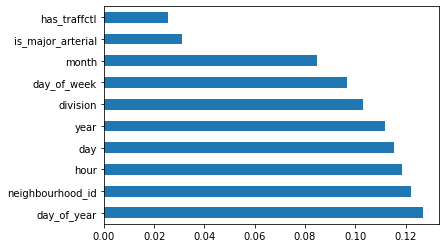

In [14]:
#use inbuilt class feature_importances of tree based classifiers

model = ExtraTreesClassifier()
model.fit(X0,y0)
print(model.feature_importances_) 

#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X0.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

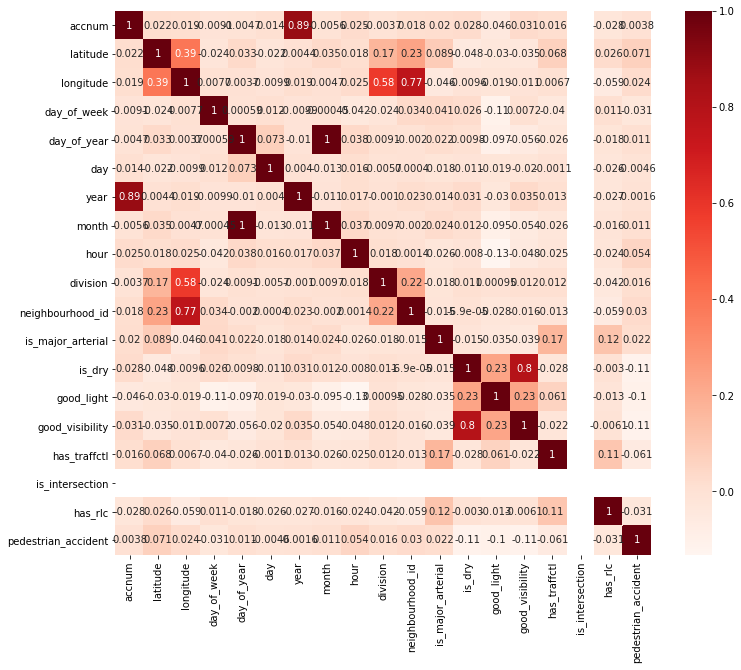

In [9]:
#Using Pearson Correlation

plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### 2. Train and test split

In [15]:
# Split test and train data
X = df.drop(['accnum', 'latitude', 'longitude', 'pedestrian_accident', 'division',
             'year', 'day'], axis=1)
y = df['pedestrian_accident']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y )

In [16]:
#check class balance
print(f'Number of pedestrian accident: {(y == 1).sum()}')
print(f'Number of none pedestrian accident: {(y == 0).sum()}')

Number of pedestrian accident: 2504
Number of none pedestrian accident: 1274


This is not balanced, we are going to add some data samples into the non-pedestrian group

In [22]:
# instantiate SMOTE
sm = SMOTETomek(random_state = 0)

# performing the SMOTE oversampling
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [23]:
# check what SMOTE has actually done
print('Original class distribution')
display(pd.Series(y_train).value_counts())

print('\nResampled class distribution')
display(pd.Series(y_train_sm).value_counts().sort_index())

Original class distribution


1    2003
0    1019
Name: pedestrian_accident, dtype: int64


Resampled class distribution


0    1812
1    1812
Name: pedestrian_accident, dtype: int64

In [24]:
# Since we later choose random forest, scaling is not needed

# Scale the train and test data
# scaler = RobustScaler()
# scaler.fit(X_train)

# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

### 3. Classifier selection

In [26]:
# Try different classifiers with pipline
classifiers = [
    KNeighborsClassifier(),
    SVC(),
    LogisticRegression(solver='liblinear'),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    XGBClassifier()
]

for classifier in classifiers:
    pipe = Pipeline(steps=[('classifier', classifier)])
    pipe.fit(X_train_sm, y_train_sm)   
    print(classifier)
    print("model score: %.3f" % pipe.score(X_test, y_test))

KNeighborsClassifier()
model score: 0.575
SVC()
model score: 0.558
LogisticRegression(solver='liblinear')
model score: 0.557
DecisionTreeClassifier()
model score: 0.565
RandomForestClassifier()
model score: 0.599
AdaBoostClassifier()
model score: 0.560
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
model score: 0.593


In [197]:
# Find the best performing parameters for random forest
param_grid = { 
    'classifier__n_estimators' : [100, 300, 500, 800, 1200],
    'classifier__max_features': ['sqrt'],
    'classifier__max_depth' : [1, 5, 10],
    'classifier__min_samples_leaf' : [1, 2, 5], 
    'classifier__criterion' : ['gini', 'entropy']
}

rf = Pipeline([('classifier', RandomForestClassifier())])
CV = GridSearchCV(rf, param_grid, cv=5, n_jobs= -1, verbose=1)

CV.fit(X_train_sm, y_train_sm)
print(CV.best_params_)
print(CV.best_score_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed:  3.2min finished


{'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 500}
0.711716621253406


In [154]:
# Tweak parameters and fit model using best performing parameters
my_rf = RandomForestClassifier(n_estimators=300,
                               max_features='sqrt',
                               max_depth=7,
                               min_samples_leaf = 2,
                               criterion='entropy')

my_rf.fit(X_train_sm, y_train_sm)

print('-----------My Best Random Forest Model-----------')
print(f' Training score: {my_rf.score(X_train_sm, y_train_sm)}')
print(f' Test score: {my_rf.score(X_test, y_test)}')

y_preds_rf = my_rf.predict(X_test)
print(classification_report(y_test,y_preds_rf))

-----------My Best Random Forest Model-----------
 Training score: 0.7440509131156613
 Test score: 0.6256613756613757
              precision    recall  f1-score   support

           0       0.46      0.63      0.53       255
           1       0.77      0.62      0.69       501

    accuracy                           0.63       756
   macro avg       0.61      0.63      0.61       756
weighted avg       0.66      0.63      0.64       756



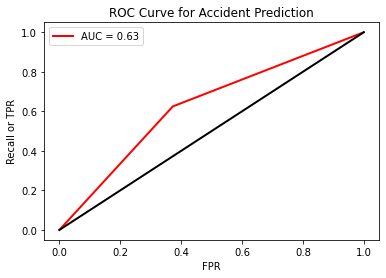

Area under curve (AUC):0.6261007396970764



In [155]:
# ROC arrays
fprs, tprs, thresholds = roc_curve(y_test, y_preds_rf)

# AUC
roc_auc = roc_auc_score(y_test, y_preds_rf)

# plot
plt.figure()
sns.lineplot(fprs, tprs, color='red', lw=2, label='AUC = %0.2f' % roc_auc)
sns.lineplot([0, 1], [0, 1], color='black', lw=2, linestyle='--') # random guess
plt.xlabel('FPR')
plt.ylabel('Recall or TPR')
plt.title('ROC Curve for Accident Prediction')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

In [32]:
# Find the best performing parameters for Gradient Boosting
param_grid = {
    'classifier__learning_rate' : [0.1],
    'classifier__min_child_weight' : [1],
    'classifier__gamma': [0, 0.1, 1],
    'classifier__n_estimators' : [100, 300, 800],
    'classifier__max_depth' : [3, 7, 15],
    'classifier__subsample': [0.1, 0.8],
    'classifier__colsample_bytree': [0.1, 0.8]
}

gb = Pipeline([('classifier', XGBClassifier())])
CV = GridSearchCV(gb, param_grid, cv=5, n_jobs= -1, verbose=1)

CV.fit(X_train_sm, y_train_sm)
print(CV.best_params_)
print(CV.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.9min finished


{'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 15, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 300, 'classifier__subsample': 0.8}
0.7644523633175628


In [158]:
# Tweak and fit model using best performing parameters
my_gb = XGBClassifier(learning_rate =0.1,
                      n_estimators=150,
                      max_depth=5,
                      min_child_weight=1,
                      gamma=0,
                      subsample=0.8,
                      colsample_bytree=0.8,
                      objective= 'binary:logistic',
                      scale_pos_weight=1,
                      seed=27)

my_gb.fit(X_train_sm, y_train_sm)

print('-----------My Best Grandient Boosting Model-----------')
print(f' Training score: {my_gb.score(X_train_sm, y_train_sm)}')
print(f' Test score: {my_gb.score(X_test, y_test)}')

y_preds_gb = my_gb.predict(X_test)
print(classification_report(y_test,y_preds_gb))

-----------My Best Grandient Boosting Model-----------
 Training score: 0.871333702268954
 Test score: 0.6097883597883598
              precision    recall  f1-score   support

           0       0.43      0.47      0.45       255
           1       0.72      0.68      0.70       501

    accuracy                           0.61       756
   macro avg       0.57      0.57      0.57       756
weighted avg       0.62      0.61      0.61       756



### 4. Export trained model

Grandient Boosting does not perform better than Random Forest, we will use fitted Random Forest for model application.

In [159]:
# Save trained random forest model for flask app
joblib.dump(my_rf, 'my_trained_model.pkl')

['my_trained_model.pkl']